In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.jet()

import sys
sys.path.insert(0, '../')
from M1S_tools import *

import matplotlib.animation as animation
from scipy.interpolate import griddata
import datetime

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
Afz =  (27685, 170)
Afx =  (27685, 170)
Afy =  (27685, 170)
U matrix (27685, 170)
V matrix (170, 170)
S matrix (170, 170)
N node =  27685
number of Mirror Front surface TCs =  48
number of Mirror Back surface TCs =  48
number of Mirro

<Figure size 640x480 with 0 Axes>

In [2]:
inputfile = '../ml_data_interface/m1s3_tc_20241209.txt'
df = pd.read_csv(inputfile, skiprows=14, nrows=154)
df
#verify that table below is 1 row more than what we need

,HEADER,Name,X,Y,Which_Scanner,Scanner_channel,Scanner_Index,Valid,Offset
0,DATA,TC1REF,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
1,DATA,MTCIN002B,-0.332903,-0.474510,0.0,1.0,0.0,1.0,0.0
2,DATA,MTCIN002M,-0.332903,-0.474510,0.0,2.0,0.0,1.0,0.0
3,DATA,MTCIN002F,-0.332892,-0.384404,0.0,3.0,0.0,1.0,0.0
4,DATA,MTC013B,-1.742551,-1.198263,0.0,4.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
149,DATA,CTCAA003,0.000000,0.000000,5.0,24.0,5.0,1.0,0.0
150,DATA,CTCCW003W,0.000000,0.000000,5.0,25.0,5.0,1.0,0.0
151,DATA,CTCCW003F,0.000000,0.000000,5.0,26.0,5.0,1.0,0.0
152,DATA,CTCIB006,0.000000,0.000000,5.0,31.0,5.0,1.0,0.0


In [3]:
# Remove the last row
df = df.iloc[:-1]

In [4]:
# Remove leading and trailing spaces from column names
df.columns = df.columns.str.strip()
# Step 2: Remove leading/trailing spaces from all string values in the DataFrame
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

In [5]:
df

,HEADER,Name,X,Y,Which_Scanner,Scanner_channel,Scanner_Index,Valid,Offset
0,DATA,TC1REF,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
1,DATA,MTCIN002B,-0.332903,-0.474510,0.0,1.0,0.0,1.0,0.0
2,DATA,MTCIN002M,-0.332903,-0.474510,0.0,2.0,0.0,1.0,0.0
3,DATA,MTCIN002F,-0.332892,-0.384404,0.0,3.0,0.0,1.0,0.0
4,DATA,MTC013B,-1.742551,-1.198263,0.0,4.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
148,DATA,CTCUP012,0.000000,0.000000,5.0,23.0,5.0,1.0,0.0
149,DATA,CTCAA003,0.000000,0.000000,5.0,24.0,5.0,1.0,0.0
150,DATA,CTCCW003W,0.000000,0.000000,5.0,25.0,5.0,1.0,0.0
151,DATA,CTCCW003F,0.000000,0.000000,5.0,26.0,5.0,1.0,0.0


In [6]:
# Logical index for rows with 'Name' starting with "MTC" and ending with "F"
idx_mirror_f1 = df['Name'].str.startswith('MTC') & df['Name'].str.endswith('F')
print('number of Mirror Front surface TCs = ', sum(idx_mirror_f1))
# Display the logical index
idx_mirror_b1 = df['Name'].str.startswith('MTC') & df['Name'].str.endswith('B')
print('number of Mirror Back surface TCs = ', sum(idx_mirror_b1))
idx_mirror_m1 = df['Name'].str.startswith('MTC') & df['Name'].str.endswith('M')
print('number of Mirror Middle TCs = ', sum(idx_mirror_m1))
idx_rtd1 = df['Name'].str.startswith('TC') & df['Name'].str.endswith('REF')
print('number of RTDs = ', sum(idx_rtd1))

number of Mirror Front surface TCs =  48
number of Mirror Back surface TCs =  48
number of Mirror Middle TCs =  16
number of RTDs =  6


In [7]:
df['Name'][1]

'MTCIN002B'

(-4.4914386, 4.4914386, -4.4902649, 4.4902649)

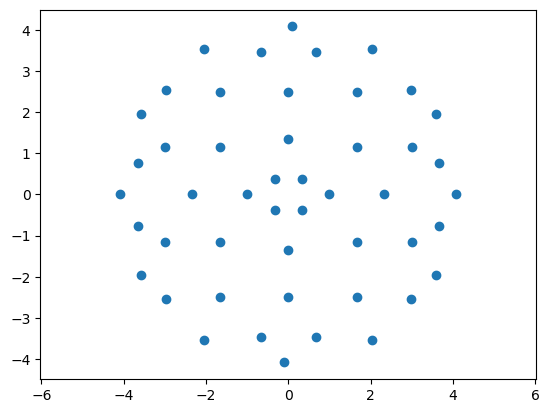

In [9]:
plt.scatter(df['X'][idx_mirror_f1], df['Y'][idx_mirror_f1])
plt.axis('equal')

(-4.590848899999999, 4.590848899999999, -4.5896587, 4.5896587)

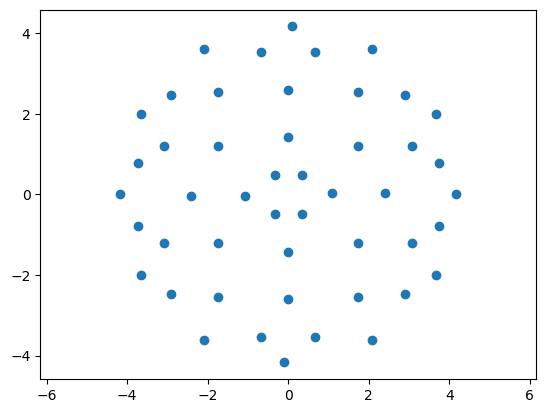

In [10]:
plt.scatter(df['X'][idx_mirror_b1], df['Y'][idx_mirror_b1])
plt.axis('equal')

(-4.590848899999999, 4.590848899999999, -4.5896587, 4.5896587)

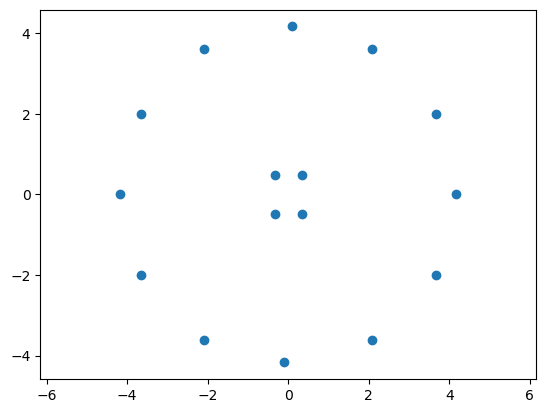

In [11]:
plt.scatter(df['X'][idx_mirror_m1], df['Y'][idx_mirror_m1])
plt.axis('equal')

In [12]:
#starting from a few hours before turning on the suckulators
#ending a few hours after turning on the suckulators
start_time = 1734445080 - 18*3600 #with the 2nd term, we start at 7:18am
end_time = 1734549480
duration = end_time - start_time

In [13]:
nsamples = 100
tc, tt = getDBData(start_time,'m1_s1_thermal_ctrl/i/tc_temperature/value', duration_in_s=duration, samples=nsamples)

m1_s1_thermal_ctrl/i/tc_temperature/value
2024-12-16 13:18:00  duration =  169200  s
(101, 6, 32)
(101, 192)


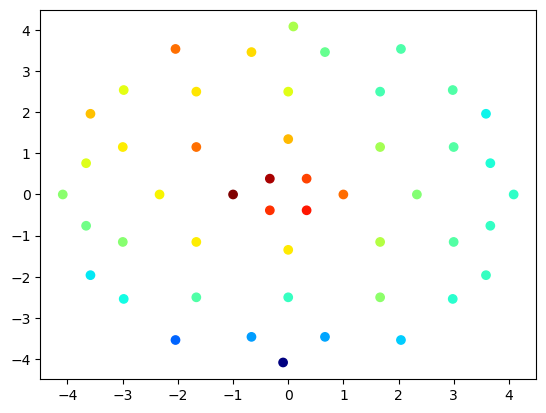

In [14]:
plt.scatter(tc_locs[idx_mirror_f,0], tc_locs[idx_mirror_f,1], c = tc[0,idx_mirror_f])

In [15]:
idx_mirror_f.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
x = tc_locs[idx_mirror_f][:,0] 
y = tc_locs[idx_mirror_f][:,1]
z = tc[0,idx_mirror_f]

# Define the grid for interpolation
grid_size = 500  # Resolution of the grid
xi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
yi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
xi, yi = np.meshgrid(xi, yi)

# Create a circular mask for the given radius
mask = np.sqrt(xi**2 + yi**2) <= radius_of_CA

# Interpolate z-values to the grid
zi = griddata((x, y), z, (xi, yi), method='linear')

# Apply the circular mask
zi[~mask] = np.nan  # Set values outside the circle to NaN

# Plot the result
plt.figure(figsize=(8, 8))
contour = plt.contourf(xi, yi, zi, levels=100, cmap='jet')
plt.colorbar(contour, label='Z values')
plt.scatter(x, y, c=z, edgecolor='k', cmap='jet', label='TCs')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Front Surface')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.legend()
plt.show()

In [ ]:
tmirror, tt = getDBData(start_time,'m1_s1_thermal_ctrl/i/mirror_temperature/value', duration_in_s=duration, samples=nsamples)
tambient, tt = getDBData(start_time,'m1_s1_thermal_ctrl/i/ambient_temperature/value', duration_in_s=duration, samples=nsamples)
time_steps = tc.shape[0]  # Number of time steps

# Define the grid for interpolation
grid_size = 500  # Resolution of the grid
xi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
yi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
xi, yi = np.meshgrid(xi, yi)

# Create a circular mask for the given radius
mask = np.sqrt(xi**2 + yi**2) <= radius_of_CA

# Set the fixed color limits (vmin, vmax) for the contour plot
tc[tc>30] = np.nan
tc[tc<10] = np.nan
vmin = np.nanmin(tambient)  # Minimum value for the colorbar
vmax = np.nanmax(tmirror)  # Maximum value for the colorbar
#levels = np.linspace(vmin, vmax, 100)  # Explicitly define levels
vmax_index = np.nanargmax(tmirror)
tt0 = tt[vmax_index]
#print('vmin, vmax, ==== ', vmin, vmax)
cbar_span = 0.6 #deg

In [ ]:
def update_plot(frame):

    if hasattr(update_plot, 'timeline'):
        update_plot.timeline.remove()
    #update_plot.timeline = ax1.axvline(x=(tt[frame]-tt0)/3600., color='r', linestyle='--', label='Current Time')
    update_plot.timeline = ax1.axvline(x=frame, color='r', linestyle='--', label='Current Time')
    ax1.set_title(f'Current Time = {datetime.datetime.fromtimestamp(tt[frame]).strftime("%Y-%m-%d %H:%M")} hours', fontsize=10)

    ax2.clear()  # **Clear the right plot (ax2)**
    # Get the data for the current time step
    x = tc_locs[idx_mirror_f][:,0]
    y = tc_locs[idx_mirror_f][:,1]
    z = tc[frame, idx_mirror_f]  # Extract z-values for the current time step

    # Interpolate z-values to the grid
    zi = griddata((x, y), z, (xi, yi), method='linear')

    # Apply the circular mask
    zi[~mask] = np.nan  # Set values outside the circle to NaN

    midpoint = np.nanmean(zi)
    levels = np.linspace(midpoint-cbar_span/2., midpoint+cbar_span/2., 100)
    zi = np.clip(zi, np.min(levels), np.max(levels))

    # Plot the contour plot
    contour = ax2.contourf(xi, yi, zi, levels=levels, cmap='jet') #use levels=levels if you want colorbar fixed!!!
    ax2.set_aspect('equal', adjustable='box')
    ax2.set_title('Front, Max - Min = %.2f Deg'%(np.nanmax(z)-np.nanmin(z)), fontsize=10)
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    if hasattr(update_plot, 'cbar2'):
        update_plot.cbar2.remove()
    #update_plot.cbar2 = fig.colorbar(contour, ax=ax2, label='Colorbar Max - Min = %.2f Deg'%cbar_span)  # Store the colorbar
    update_plot.cbar2 = fig.colorbar(contour, ax=ax2, format='%.2f')#, label='Temperature')  # Store the colorbar
    #update_plot.cbar2.set_ticks(np.linspace(vmin, vmax, num=5))
    ax2.scatter(x, y, c=z, edgecolor='k', cmap='jet', vmin=np.min(levels), vmax=np.max(levels), label='TCs')
    #ax2.legend(loc='upper right')

    #ax3 for middle
    ax3.clear()
    x = tc_locs[idx_mirror_m][:,0]
    y = tc_locs[idx_mirror_m][:,1]
    z = tc[frame, idx_mirror_m]
    zi = griddata((x, y), z, (xi, yi), method='linear')
    zi[~mask] = np.nan  # Set values outside the circle to NaN

    midpoint = np.nanmean(zi)
    levels = np.linspace(midpoint-cbar_span/2., midpoint+cbar_span/2., 100)
    zi = np.clip(zi, np.min(levels), np.max(levels))

    contour = ax3.contourf(xi, yi, zi, levels=levels, cmap='jet')
    ax3.set_aspect('equal', adjustable='box')
    ax3.set_title('Middle, Max - Min = %.2f Deg'%(np.nanmax(zi)-np.nanmin(zi)), fontsize=10)
    ax3.set_xlabel('X (m)')
    ax3.set_ylabel('Y (m)')
    if hasattr(update_plot, 'cbar3'):
        update_plot.cbar3.remove()
    update_plot.cbar3 = fig.colorbar(contour, ax=ax3, format='%.2f')#, label='Temperature')  # Store the colorbar
    ax3.scatter(x, y, c=z, edgecolor='k', vmin=np.min(levels), vmax=np.max(levels), cmap='jet', label='TCs')
    #ax3.legend(loc='upper right')

    #ax4 for back
    ax4.clear()
    x = tc_locs[idx_mirror_b][:,0]
    y = tc_locs[idx_mirror_b][:,1]
    z = tc[frame, idx_mirror_b]
    zi = griddata((x, y), z, (xi, yi), method='linear')
    zi[~mask] = np.nan  # Set values outside the circle to NaN

    midpoint = np.nanmean(zi)
    levels = np.linspace(midpoint-cbar_span/2., midpoint+cbar_span/2., 100)
    zi = np.clip(zi, np.min(levels), np.max(levels))

    contour = ax4.contourf(xi, yi, zi, levels=levels, cmap='jet')
    ax4.set_aspect('equal', adjustable='box')
    ax4.set_title('Back, Max - Min = %.2f Deg'%(np.nanmax(zi)-np.nanmin(zi)), fontsize=10)
    ax4.set_xlabel('X (m)')
    #ax4.set_ylabel('Y (m)')
    if hasattr(update_plot, 'cbar4'):
        update_plot.cbar4.remove()
    update_plot.cbar4 = fig.colorbar(contour, ax=ax4, format='%.2f')#, label='Temperature')  # Store the colorbar
    ax4.scatter(x, y, c=z, edgecolor='k', cmap='jet', vmin=np.min(levels), vmax=np.max(levels), label='TCs')
    #ax4.legend(loc='upper right')

    #ax4 for back
    ax5.clear()
    x = tc_locs[idx_mirror_b][:,0]
    y = tc_locs[idx_mirror_b][:,1]
    z = tc[frame, idx_mirror_b] - tc[frame, idx_mirror_f]
    zi = griddata((x, y), z, (xi, yi), method='linear')
    zi[~mask] = np.nan  # Set values outside the circle to NaN

    midpoint = np.nanmean(zi)
    levels = np.linspace(midpoint-cbar_span/2., midpoint+cbar_span/2., 100)
    zi = np.clip(zi, np.min(levels), np.max(levels))

    contour = ax5.contourf(xi, yi, zi, levels=levels, cmap='jet')
    ax5.set_aspect('equal', adjustable='box')
    ax5.set_title('Back-Front, Max - Min = %.2f Deg'%(np.nanmax(zi)-np.nanmin(zi)), fontsize=10)
    ax5.set_xlabel('X (m)')
    #ax5.set_ylabel('Y (m)')
    if hasattr(update_plot, 'cbar5'):
        update_plot.cbar5.remove()
    update_plot.cbar5 = fig.colorbar(contour, ax=ax5, format='%.2f')#, label='Temperature')  # Store the colorbar
    ax5.scatter(x, y, c=z, edgecolor='k', cmap='jet', vmin=np.min(levels), vmax=np.max(levels), label='TCs')
    #ax5.legend(loc='upper right')
    
    # Redraw the figure
    plt.draw()

In [ ]:
# Create the figure and axis for the subplots (2 panels)
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))  # **Create 2 subplots: left (ax1) for tmirror, right (ax2) for contour plot**
#fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)

ax1 = plt.subplot2grid(shape=(2, 3), loc=(0,0), colspan=2) #HD
ax2 = plt.subplot2grid(shape=(2, 3), loc=(1,0)) #front surf
ax3 = plt.subplot2grid(shape=(2, 3), loc=(0,2)) #middle
ax4 = plt.subplot2grid(shape=(2, 3), loc=(1,1)) #back
ax5 = plt.subplot2grid(shape=(2, 3), loc=(1,2)) #back-front

# Plot the tmirror on the left (ax1)  **New: Plot `tmirror` over time on the left panel**
time_labels = [datetime.datetime.fromtimestamp(ts).strftime('%H:%M') for ts in tt]
ax1.plot(time_labels, tmirror, label="Mirror Temperature", color="b")
ax1.plot(time_labels, tambient, label="Ambient Temperature", color="k")
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Mirror Temperature (°C)')
#ax1.set_title('Mirror Temperature over Time')
ax1.set_ylim(min(tambient)-0.2*(vmax-vmin), max(tmirror)+0.2*(vmax-vmin))  # Adjust y-axis based on your data
timeline = ax1.axvline(x=(tt[0]-tt0)/3600., color='r', linestyle='--', label='Current Time')
ax1.legend(loc='upper right')
timeline.remove()
ax1.grid()
ax1.set_xticks(ticks=np.arange(0, len(time_labels), step=10), labels=[time_labels[i] for i in range(0, len(time_labels), 10)])

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=time_steps, repeat=False)
#ani = animation.FuncAnimation(fig, update_plot, frames=1, repeat=False)

# Save the animation as an MP4 file
ani.save('tc_surface_animation.mp4', writer='ffmpeg', fps=5)  # Modify fps as needed

In [ ]:
np.sum(logical_index)

### Does the front and back TC's line up in x and y?

In [ ]:
np.max(tc_locs[idx_mirror_b][:,0]-tc_locs[idx_mirror_f][:,0])

In [ ]:
np.max(tc_locs[idx_mirror_b][:,1]-tc_locs[idx_mirror_f][:,1])